<a href="https://colab.research.google.com/github/Amanda-Sibanda/agriBORA-Commodity-Price-Forecasting/blob/main/Feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

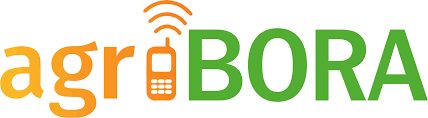

#****agriBORA Commodity Price Forecasting****

Smallholder farmers in Kenya face significant maize price volatility and high post-harvest losses. agriBORA helps farmers store their produce safely and access credit, but effective decision-making still depends on knowing when to sell for the best price.

In this project, we use historical weekly maize prices to build a machine learning model that forecasts average prices for Kiambu, Kirinyaga, Mombasa, Nairobi, and Uasin-Gishu.
The model must predict two weeks ahead at each step, covering the period from November 17, 2025 to January 10, 2026.

Accurate forecasts will support better market timing, improve farmer earnings, and strengthen agriBORA’s market intelligence tools.

In [172]:
# Import libraries
from matplotlib.colors import LinearSegmentedColormap
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

In [173]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
path = "/content/drive/MyDrive/agribora-commodity-price-forecasting-challenge20251124-1142-1vfhirx/"

**Data**

* First dataset is from ***Kamis***,  the Kenya Agricultural Market Information System. It is a state portal by Kenya's Ministry of Agriculture that provides real-time market data on commodity prices and conditions to farmers and traders.
 It consists of historical prices for white maize from 2021 - 2025/07.
The dataframe has 3345 rows and 15 columns.

*   Second dataset is from ***AgriBBORA***, an agri fintech company that protects grain, unlocks instant financing and links farmers and agriHUBS to reliable markets across East Africa. It consists of transaction data between businesses showing the weekly white maize prices from 2023/10 - 2025/10.
The dataframe has 749 rows and 6 columns.

* Third dataset is the overlapping data between the ***AgriBORA*** and ***Kamis*** datasets. It has 1058 rows and 14 columns.


In [175]:
# Load data
data = pd.read_csv(path +'merged_cleaned_20260212.csv')

In [176]:
data.head()

,Commodity_Classification_kamis,Commodity,Classification,County,Market,Date,Year,Month,Year_Month,WeekofYear,Year_Week,SupplyVolume,Retail,Wholesale_kamis,Commodity_Classification_agribora,Wholesale_agribora
0,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021,5,2021-05,21,2021-21,9000.0,40.0,30.00,Dry_White_Maize,42.22
1,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Limuru_Rongai_Market,2021-05-24,2021,5,2021-05,21,2021-21,7200.0,40.0,28.89,Dry_White_Maize,42.22
2,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Limuru_Rongai_Market,2021-05-24,2021,5,2021-05,21,2021-21,45000.0,35.0,30.00,Dry_White_Maize,42.22
3,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021,5,2021-05,21,2021-21,18000.0,45.0,20.00,Dry_White_Maize,42.22
4,Dry_White_Maize,Dry_Maize,White_Maize,Kiambu,Wangige_Market,2021-05-24,2021,5,2021-05,21,2021-21,4000.0,50.0,32.22,Dry_White_Maize,42.22


In [177]:
# Convert to datetime (if not already)
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # invalid parsing becomes NaT

# Now extract Day
data['Day'] = data['Date'].dt.day

In [178]:
# Drop columns with little to no infromation value and redudant columns
cols_to_drop = ['Commodity_Classification_kamis','Commodity_Classification_agribora','Commodity','Classification', 'Date', 'Year_Month', 'Year_Week']
data = data.drop(columns=cols_to_drop)


In [179]:
# Create date column
data['Date'] = pd.to_datetime(dict(
    year=data['Year'],
    month=data['Month'],
    day=data['Day']
))

**Reindex to Full Daily Calendar**

In [180]:
# First sort data properly
data = data.sort_values(['Market', 'Date'])

In [181]:
# Create full date range per market
data = data.sort_values(['Market', 'Date'])

full_data = []

for market in data['Market'].unique():
    temp = data[data['Market'] == market].copy()

    # Aggregate duplicates for the same Market and Date before setting index
    temp = temp.groupby('Date').mean(numeric_only=True).reset_index()

    full_range = pd.date_range(
        start=temp['Date'].min(),
        end=temp['Date'].max(),
        freq='D'
    )

    temp = temp.set_index('Date').reindex(full_range)
    temp['Market'] = market

    full_data.append(temp)

data = pd.concat(full_data).reset_index().rename(columns={'index': 'Date'})

In [182]:
# If market closed that day, forward fill
data[['Wholesale_agribora', 'Retail', 'Wholesale_kamis']] = (
    data.groupby('Market')[['Wholesale_agribora', 'Retail', 'Wholesale_kamis']]
    .ffill()
)

In [183]:
# If no supply that day, set supply to zero
data['SupplyVolume'] = data['SupplyVolume'].fillna(0)

**Fill missing dates caused by indexing**

In [184]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['WeekofYear'] = data['Date'].dt.isocalendar().week.astype(int)


**Time features**

In [185]:
# Day of week
data['DayOfWeek'] = data['Date'].dt.dayofweek   # 0=Mon, 6=Sun
data['IsWeekend'] = (data['DayOfWeek'] >= 5).astype(int)

# Day of year
data['DayOfYear'] = data['Date'].dt.dayofyear

# Quarter
data['Quarter'] = data['Date'].dt.quarter

# Month-start/ Month-end
data['IsMonthStart'] = data['Date'].dt.is_month_start.astype(int)
data['IsMonthEnd'] = data['Date'].dt.is_month_end.astype(int)

**Cyclical encoding**

In [186]:
# Month
data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# Day of the week
data['Dow_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['Dow_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

# Week of the year
data['Week_sin'] = np.sin(2 * np.pi * data['WeekofYear'] / 52)
data['Week_cos'] = np.cos(2 * np.pi * data['WeekofYear'] / 52)

**Seasonal effects**

In [187]:
# Flag for weeks 51, 52, and 1 as Holiday effect
data['Is_holiday'] = data['WeekofYear'].apply(lambda x: 1 if x in [51, 52, 1] else 0)

**Lag features**

In [188]:
# 1-day lag
data['agribora_lag_1'] = (
    data.groupby('Market')['Wholesale_agribora'].shift(1)
)

# 7-day lag (weekly pattern)
data['agribora_lag_7'] = (
    data.groupby('Market')['Wholesale_agribora'].shift(7)
)

# 14-day lag (bi-weekly)
data['agribora_lag_14'] = (
    data.groupby('Market')['Wholesale_agribora'].shift(14)
)

# 30-day lag (monthly memory)
data['agribora_lag_30'] = (
    data.groupby('Market')['Wholesale_agribora'].shift(30)
)

**Rolling features**

In [189]:
# 7-day rolling mean
data['agribora_roll_mean_7'] = (
    data.groupby('Market')['Wholesale_agribora']
    .transform(lambda x: x.shift(1).rolling(7).mean())
)

# 14-day rolling mean
data['agribora_roll_mean_14'] = (
    data.groupby('Market')['Wholesale_agribora']
    .transform(lambda x: x.shift(1).rolling(14).mean())
)

# Rolling volatility
data['agribora_roll_std_7'] = (
    data.groupby('Market')['Wholesale_agribora']
    .transform(lambda x: x.shift(1).rolling(7).std())
)


**Cross-feature lags**

In [190]:
# Retail lag
data['retail_lag_1'] = (
    data.groupby('Market')['Retail'].shift(1)
)

# Kamis lag
data['kamis_lag_1'] = (
    data.groupby('Market')['Wholesale_kamis'].shift(1)
)

# Supply volume lag
data['supply_lag_1'] = (
    data.groupby('Market')['SupplyVolume'].shift(1)
)

**Supply features and intereaction terms**

In [191]:
data['supply_lag_1'] = (
    data.groupby('Market')['SupplyVolume'].shift(1)
)

data['supply_lag_7'] = (
    data.groupby('Market')['SupplyVolume'].shift(7)
)

In [192]:
#Supply rolling averages (supply pressure)

data['supply_roll_mean_7'] = (
    data.groupby('Market')['SupplyVolume']
    .transform(lambda x: x.shift(1).rolling(7).mean())
)

data['supply_roll_std_7'] = (
    data.groupby('Market')['SupplyVolume']
    .transform(lambda x: x.shift(1).rolling(7).std())
)

In [193]:
# Supply momentum (change in supply)
data['supply_diff_1'] = (
    data.groupby('Market')['SupplyVolume'].diff(1)
)

In [194]:
# Interaction terms
data['supply_x_retail'] = (
    data['SupplyVolume'] * data['Retail']
)

data['supply_x_kamis'] = (
    data['SupplyVolume'] * data['Wholesale_kamis']
)

data['retail_x_kamis'] = (
    data['Retail'] * data['Wholesale_kamis']
)

data['relative_supply'] = (
    data['SupplyVolume'] /
    data.groupby('Market')['SupplyVolume'].transform('mean')
)

data['supply_pressure_ratio'] = (  # If > 1 → unusual supply spike , If < 1 → tight supply
    data['SupplyVolume'] /
    (data['supply_roll_mean_7'] + 1)
)

In [195]:
data.isna().sum()

,0
Date,0
Year,0
Month,0
WeekofYear,0
SupplyVolume,0
Retail,0
Wholesale_kamis,0
Wholesale_agribora,0
Day,0
Market,0


In [196]:
data.dropna(inplace=True)

In [197]:
data.columns

Index(['Date', 'Year', 'Month', 'WeekofYear', 'SupplyVolume', 'Retail',
       'Wholesale_kamis', 'Wholesale_agribora', 'Day', 'Market', 'DayOfWeek',
       'IsWeekend', 'DayOfYear', 'Quarter', 'IsMonthStart', 'IsMonthEnd',
       'Month_sin', 'Month_cos', 'Dow_sin', 'Dow_cos', 'Week_sin', 'Week_cos',
       'Is_holiday', 'agribora_lag_1', 'agribora_lag_7', 'agribora_lag_14',
       'agribora_lag_30', 'agribora_roll_mean_7', 'agribora_roll_mean_14',
       'agribora_roll_std_7', 'retail_lag_1', 'kamis_lag_1', 'supply_lag_1',
       'supply_lag_7', 'supply_roll_mean_7', 'supply_roll_std_7',
       'supply_diff_1', 'supply_x_retail', 'supply_x_kamis', 'retail_x_kamis',
       'relative_supply', 'supply_pressure_ratio'],
      dtype='object')

In [198]:
data.head(10)

,Date,Year,Month,WeekofYear,SupplyVolume,Retail,Wholesale_kamis,Wholesale_agribora,Day,Market,...,supply_lag_1,supply_lag_7,supply_roll_mean_7,supply_roll_std_7,supply_diff_1,supply_x_retail,supply_x_kamis,retail_x_kamis,relative_supply,supply_pressure_ratio
30,2023-11-02,2023,11,44,0.0,56.666667,50.74,41.11,2,Business,...,0.0,0.000000,1497.619048,2568.513559,0.0,0.0,0.0,2875.266667,0.000000,0.000000
31,2023-11-03,2023,11,44,4500.0,60.000000,44.72,43.89,3,Business,...,0.0,0.000000,1497.619048,2568.513559,4500.0,270000.0,201240.0,2683.200000,3.903764,3.002764
32,2023-11-04,2023,11,44,0.0,60.000000,44.72,43.89,4,Business,...,4500.0,5650.000000,2140.476190,2691.410499,-4500.0,0.0,0.0,2683.200000,0.000000,0.000000
33,2023-11-05,2023,11,44,0.0,60.000000,44.72,43.89,5,Business,...,0.0,0.000000,1333.333333,2279.132389,0.0,0.0,0.0,2683.200000,0.000000,0.000000
34,2023-11-06,2023,11,45,0.0,60.000000,44.72,43.89,6,Business,...,0.0,4833.333333,1333.333333,2279.132389,0.0,0.0,0.0,2683.200000,0.000000,0.000000
35,2023-11-07,2023,11,45,0.0,60.000000,44.72,43.89,7,Business,...,0.0,0.000000,642.857143,1700.840129,0.0,0.0,0.0,2683.200000,0.000000,0.000000
36,2023-11-08,2023,11,45,4375.0,60.000000,47.22,41.11,8,Business,...,0.0,0.000000,642.857143,1700.840129,4375.0,262500.0,206587.5,2833.200000,3.795326,6.794986
37,2023-11-09,2023,11,45,0.0,60.000000,47.22,41.11,9,Business,...,4375.0,0.000000,1267.857143,2165.578939,-4375.0,0.0,0.0,2833.200000,0.000000,0.000000
38,2023-11-10,2023,11,45,0.0,60.000000,47.22,41.11,10,Business,...,0.0,4500.000000,1267.857143,2165.578939,0.0,0.0,0.0,2833.200000,0.000000,0.000000
39,2023-11-11,2023,11,45,0.0,60.000000,47.22,41.11,11,Business,...,0.0,0.000000,625.000000,1653.594569,0.0,0.0,0.0,2833.200000,0.000000,0.000000


In [199]:
data.shape

(20658, 42)

**Quick data distribution analysis to ensure data accuracy after feature engineering**

In [200]:
# Select only numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print(numeric_cols)

['Year', 'Month', 'WeekofYear', 'SupplyVolume', 'Retail', 'Wholesale_kamis', 'Wholesale_agribora', 'Day', 'DayOfWeek', 'IsWeekend', 'DayOfYear', 'Quarter', 'IsMonthStart', 'IsMonthEnd', 'Month_sin', 'Month_cos', 'Dow_sin', 'Dow_cos', 'Week_sin', 'Week_cos', 'Is_holiday', 'agribora_lag_1', 'agribora_lag_7', 'agribora_lag_14', 'agribora_lag_30', 'agribora_roll_mean_7', 'agribora_roll_mean_14', 'agribora_roll_std_7', 'retail_lag_1', 'kamis_lag_1', 'supply_lag_1', 'supply_lag_7', 'supply_roll_mean_7', 'supply_roll_std_7', 'supply_diff_1', 'supply_x_retail', 'supply_x_kamis', 'retail_x_kamis', 'relative_supply', 'supply_pressure_ratio']


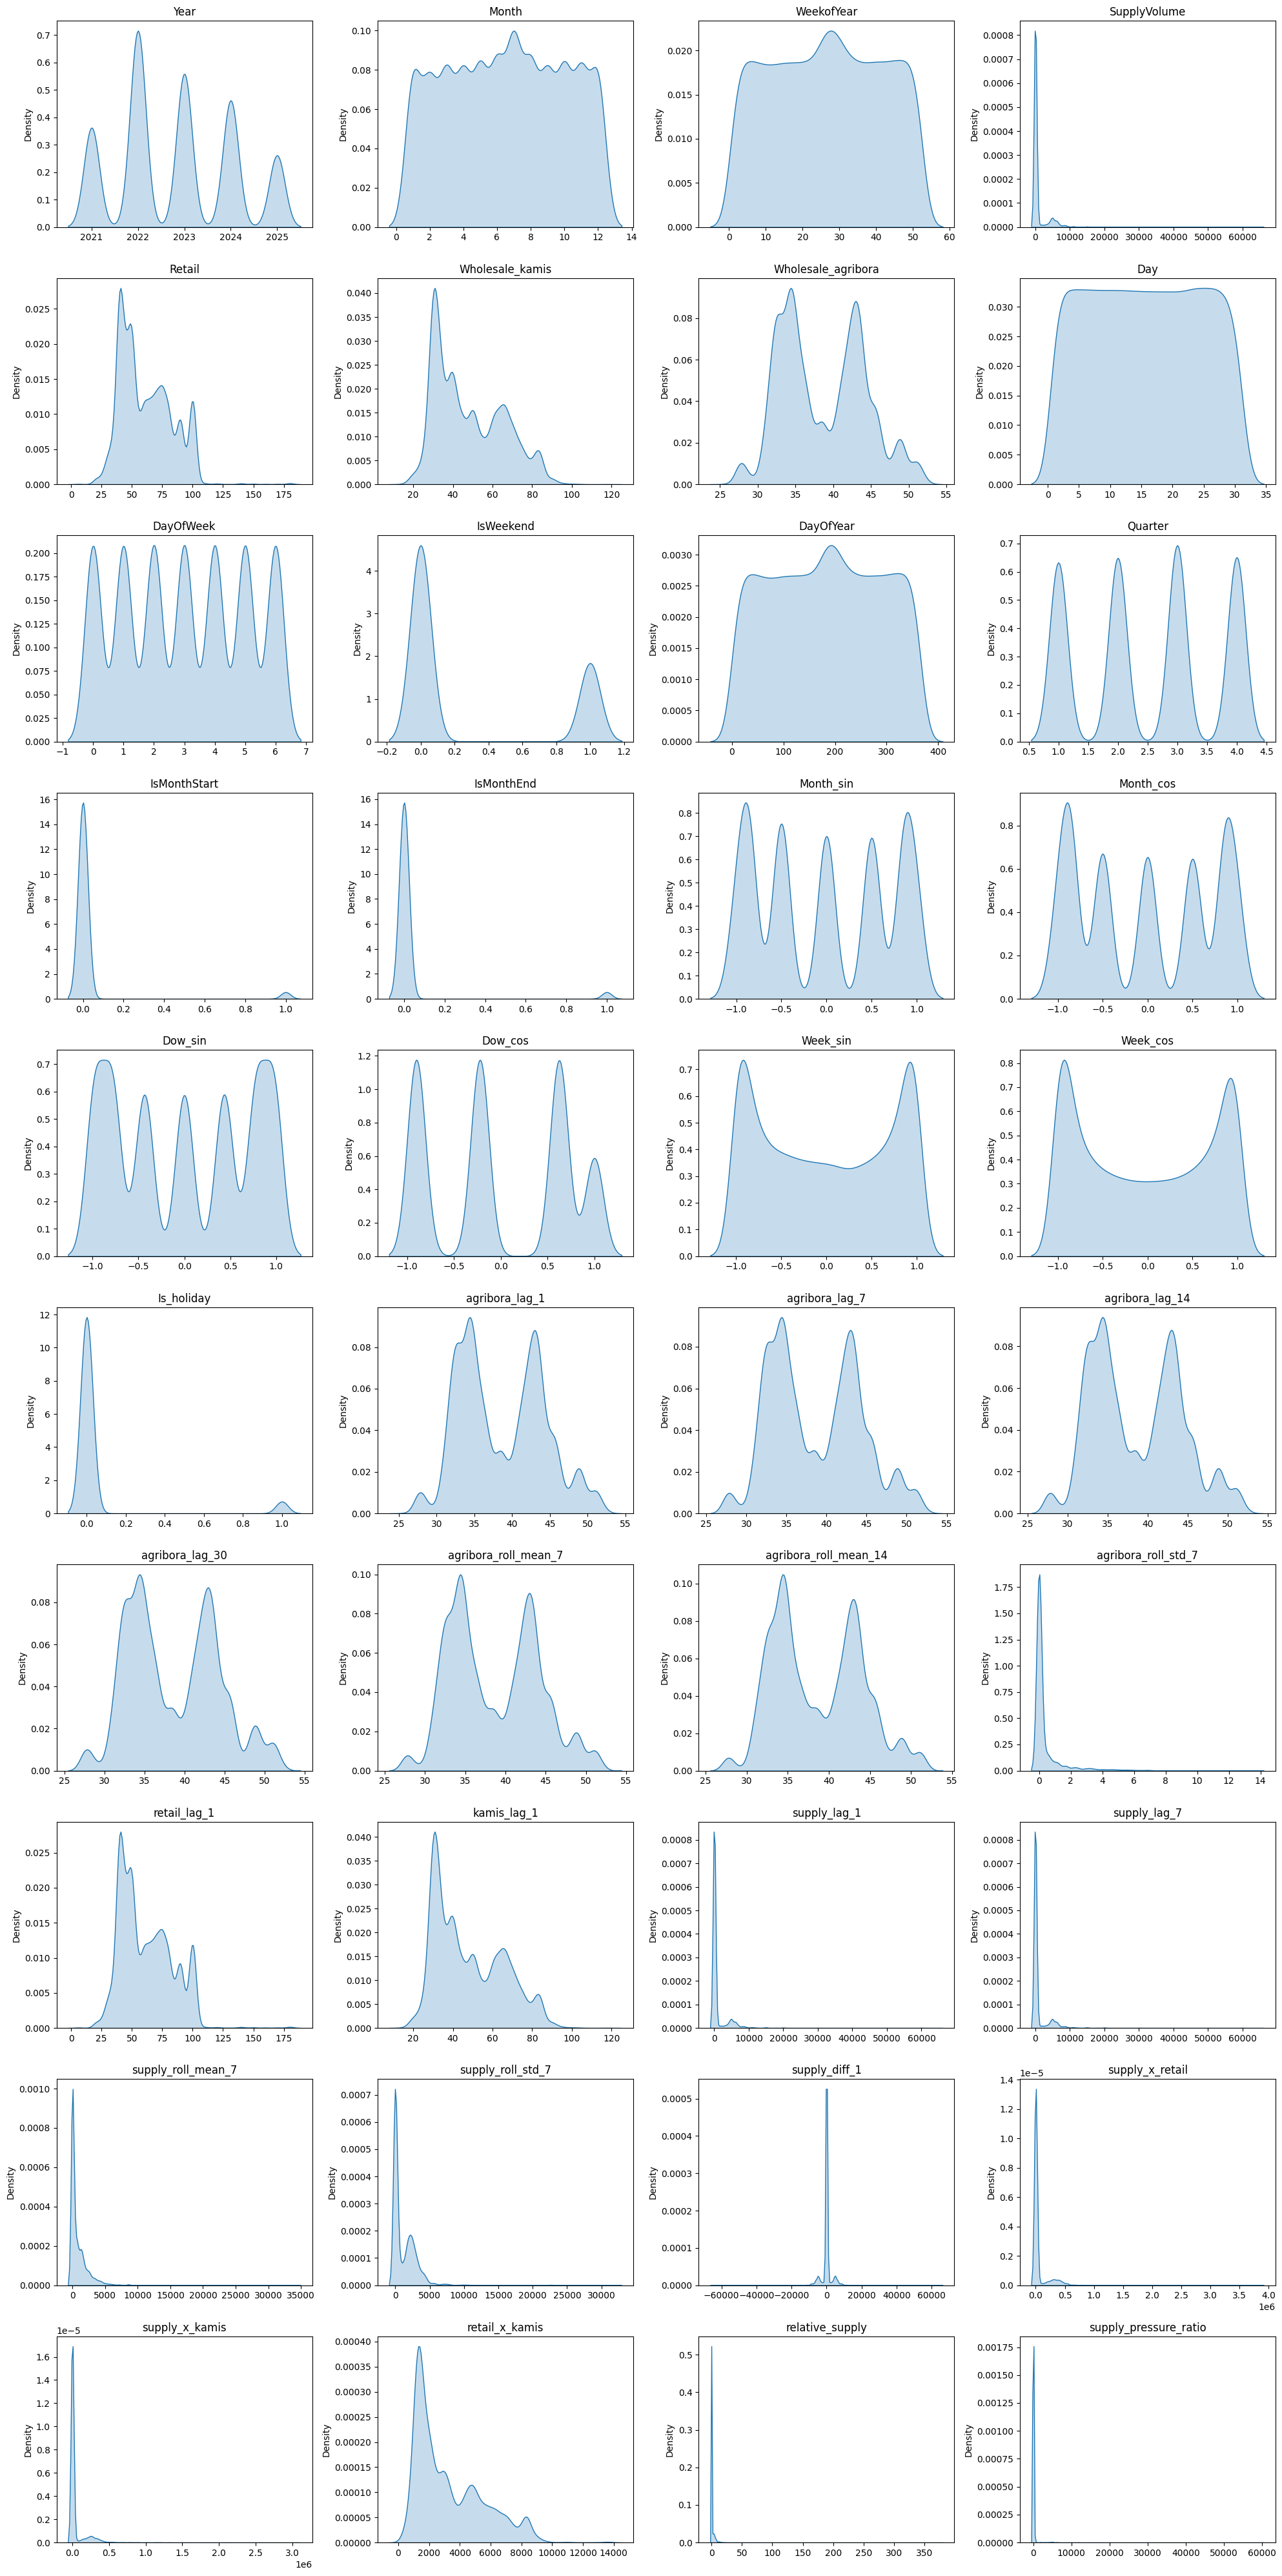

In [201]:
# Number of columns in grid
n_cols = 4
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.kdeplot(data[col].dropna(), fill=True, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Save feature engineered data**

In [202]:
# Generate a timestamp string
timestamp = datetime.now().strftime("%Y%m%d")

# Save kamis_df
data.to_csv(f'data_feature_engineered_{timestamp}.csv', index=False)
